In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import data_processing
import math
import ipympl
from scipy import stats
from numpy import NaN
from matplotlib.pyplot import box
from sklearn.linear_model import LinearRegression


In [2]:
NUM_SAMPLES_BUFFER = 600
FILTER_AFTER_N = 200
BP_LOW_CUTOFF = 20
BP_HIGH_CUTOFF = 500
ORDER = 2
LP_HIGH_CUTOFF = 5

Mvc = 379.6267184490227
percent_mvc = 0.3
mvc_threshold = percent_mvc*Mvc

In [3]:
%matplotlib widget

In [4]:
data1_haptics = np.loadtxt("Dailyn/with_feedback/raw_data_20220805-142247")
data2_haptics = np.loadtxt("Dailyn/with_feedback/raw_data_20220805-143530")
data3_haptics = np.loadtxt("Dailyn/with_feedback/raw_data_20220805-143804")

data_timestamps1_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_data_20220805-142247")
data_timestamps2_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_data_20220805-143530")
data_timestamps3_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_data_20220805-143804")

data_crossed1_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_crossed_data_20220805-142247")
data_crossed2_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_crossed_data_20220805-143530")
data_crossed3_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_crossed_data_20220805-143804")

gui_data1_haptics = np.load("Dailyn/with_feedback/combo_info_20220805-142239.npz")
gui_data2_haptics = np.load("Dailyn/with_feedback/combo_info_20220805-143431.npz")
gui_data3_haptics = np.load("Dailyn/with_feedback/combo_info_20220805-143759.npz")


In [ ]:
data1_wo = np.loadtxt("Dailyn/wo_feedback/raw_data_20220805-142247")
data2_wo = np.loadtxt("Dailyn/wo_feedback/raw_data_20220805-143530")
data3_wo = np.loadtxt("Dailyn/wo_feedback/raw_data_20220805-143804")

data_timestamps1__wo = np.loadtxt("Dailyn/wo_feedback/timestamp_data_20220805-142247")
data_timestamps2__wo = np.loadtxt("Dailyn/wo_feedback/timestamp_data_20220805-143530")
data_timestamps3__wo = np.loadtxt("Dailyn/wo_feedback/timestamp_data_20220805-143804")

data_crossed1__wo = np.loadtxt("Dailyn/wo_feedback/timestamp_crossed_data_20220805-142247")
data_crossed2__wo = np.loadtxt("Dailyn/wo_feedback/timestamp_crossed_data_20220805-143530")
data_crossed3__wo = np.loadtxt("Dailyn/wo_feedback/timestamp_crossed_data_20220805-143804")

gui_data1_wo = np.load("Dailyn/wo_feedback/combo_info_20220805-142239.npz")
gui_data2_wo = np.load("Dailyn/wo_feedback/combo_info_20220805-143431.npz")
gui_data3_wo = np.load("Dailyn/wo_feedback/combo_info_20220805-143759.npz")

In [5]:
gui_combos_haptics = np.concatenate((gui_data1_haptics['combos'], gui_data2_haptics['combos'], gui_data3_haptics['combos']), axis=0)
gui_reps_haptics = gui_data1_haptics['reps']

print("repitions:", gui_reps_haptics)
print('Wt/Dt combos:', gui_combos_haptics)

ID_haptics = np.log2(gui_combos_haptics[:,1]/gui_combos_haptics[:,0])
print("ID:",ID_haptics)

repitions: 25
Wt/Dt combos: [[ 230 1600]
 [ 230 1000]
 [ 230 2200]
 [  60 1600]
 [  60 2200]
 [  60 1000]
 [ 150 1600]
 [ 150 1000]
 [ 150 2200]]
ID: [2.79836614 2.12029423 3.25779776 4.73696559 5.19639721 4.05889369
 3.4150375  2.73696559 3.87446912]


In [6]:
def remove_trailing_zeros(data, data_timestamps, data_crossed):
    data_new = data[~(data == 0).all(axis=1)]
    timestamp_data_new = data_timestamps[~(data == 0).all(axis=1)]
    data_crossed_new = data_crossed[~(data_crossed == 0)]
    return data_new, timestamp_data_new, data_crossed_new

def zero_runs(a):
    iszero = np.equal(a, 0).view(np.int8)
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def remove_long_runs(runs, data):
    runs_lengths = runs[:,1] - runs[:,0]

    for idx, length in enumerate(runs_lengths):
        if length > 2000:
            data[runs[idx,0]-1:runs[idx,1]+1] = 1 

    return data 

In [25]:
data1_haptics, data_timestamps1_haptics, data_crossed1_haptics  = remove_trailing_zeros(data1_haptics, data_timestamps1_haptics, data_crossed1_haptics)
data2_haptics, data_timestamps2_haptics, data_crossed2_haptics  = remove_trailing_zeros(data2_haptics, data_timestamps2_haptics, data_crossed2_haptics)
data3_haptics, data_timestamps3_haptics, data_crossed3_haptics  = remove_trailing_zeros(data3_haptics, data_timestamps3_haptics, data_crossed3_haptics)

data_crossed1_haptics = data_crossed1_haptics - data_timestamps1_haptics[0]
data_timestamps1_haptics = data_timestamps1_haptics - data_timestamps1_haptics[0]

data_crossed2_haptics = data_crossed2_haptics - data_timestamps2_haptics[0] + data_timestamps1_haptics[-1]
data_timestamps2_haptics = data_timestamps2_haptics - data_timestamps2_haptics[0] + data_timestamps1_haptics[-1]


data_crossed3_haptics = data_crossed3_haptics - data_timestamps3_haptics[0] + data_timestamps2_haptics[-1]
data_timestamps3_haptics = data_timestamps3_haptics - data_timestamps3_haptics[0] + data_timestamps2_haptics[-1]

data1_haptics[:, 4] = remove_long_runs(zero_runs(data1_haptics[:, 4]), data1_haptics[:, 4])
data2_haptics[:, 4] = remove_long_runs(zero_runs(data2_haptics[:, 4]), data2_haptics[:, 4])
data3_haptics[:, 4] = remove_long_runs(zero_runs(data3_haptics[:, 4]), data3_haptics[:, 4])

data_crossed_haptics = np.concatenate((data_crossed1_haptics, data_crossed2_haptics, data_crossed3_haptics), axis = 0)
data_timestamps_haptics = np.concatenate((data_timestamps1_haptics, data_timestamps2_haptics, data_timestamps3_haptics), axis=0)
data_haptics = np.concatenate((data1_haptics, data2_haptics, data3_haptics), axis=0)

In [26]:
# # plt.figure()
# fig, axs = plt.subplots(3, figsize=(10, 5), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

# axs[0].plot(data_timestamps1, data1_haptics[:, 0])
# axs[0].plot(data_timestamps1, data1_haptics[:, 4])
# axs[0].title.set_text('EMG')


# axs[1].plot(data_timestamps2, data2_haptics[:, 0])
# axs[1].plot(data_timestamps2, data2_haptics[:, 4])
# axs[1].title.set_text('EMG')

# axs[2].plot(data_timestamps3, data3_haptics[:, 0])
# axs[2].plot(data_timestamps3, data3_haptics[:, 4])
# axs[2].title.set_text('EMG')

Text(0.5, 1.0, 'EMG')

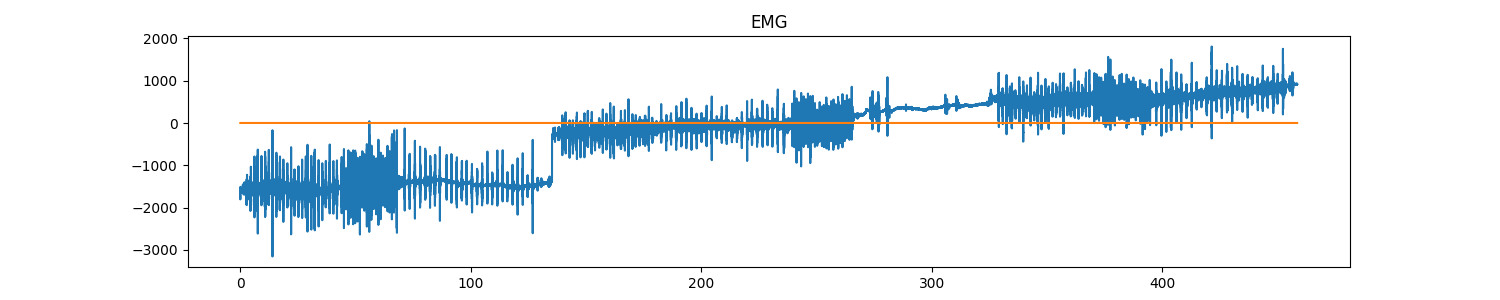

In [27]:
fig, axs = plt.subplots(1, figsize=(15, 3), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

plt.plot(data_timestamps_haptics, data_haptics[:, 0])
plt.plot(data_timestamps_haptics, data_haptics[:, 4])
plt.title('EMG')


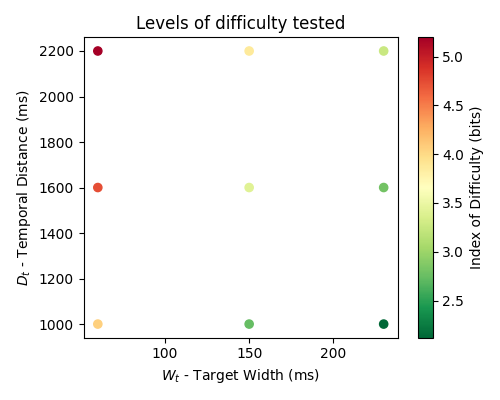

In [28]:
# Plot difficulty range
plt.figure(figsize=(5,4))
plt.scatter(gui_combos_haptics[:,0], gui_combos_haptics[:,1], c=ID_haptics, s=35)
plt.title('Levels of difficulty tested')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('$D_{t}$ - Temporal Distance (ms)')
plt.set_cmap('RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Index of Difficulty (bits)')
plt.tight_layout()
plt.show()

In [29]:
# fig,ax = plt.subplots(1, figsize=(5, 2))
# plt.scatter(ID, np.zeros(np.size(ID)), alpha=0.5)
# # Turn off tick labels
# ax.set_yticklabels([])
# ax.set_yticks([])
# plt.title("Index of Difficulty")
# plt.xlabel("Index of Difficulty")
# plt.show()


In [30]:
# print(data_timestamps)
# print(data_crossed)

In [31]:


process = data_processing.postProcessData(4000, data_haptics[:,0])
process.processAll(BP_LOW_CUTOFF, BP_HIGH_CUTOFF, LP_HIGH_CUTOFF, ORDER, FILTER_AFTER_N)


In [32]:

def findThresholdCrossing(lpData, threshold):
    threshold_crossings = np.diff(lpData > threshold, prepend=False)
    positive_difference = np.diff(lpData, prepend=0) >= 0 
    threshold_crossings_positive = np.argwhere(np.logical_and(threshold_crossings, positive_difference))[:,0]
    return threshold_crossings_positive

threshold_crossings_up = findThresholdCrossing(process.lpFilteredData, mvc_threshold)

def thresholdCrossed(lpData, threshold):
    threshold_crossings = np.diff(lpData > threshold)
    print("function crossing", threshold_crossings)
    positive_difference = np.diff(lpData) > 0    
    print("funciton difference", positive_difference) 
    thresholdCrossed =  np.any(np.logical_and(threshold_crossings, positive_difference))
    return thresholdCrossed

stop_cue = (np.where(np.diff(data_haptics[:, 4]) == 1)[0])
start_cue = (np.where(np.diff(data_haptics[:, 4]) == -1)[0])

if stop_cue[0] < start_cue[0]:
    stop_cue = stop_cue[1:]

print("threshold corssing:", threshold_crossings_up)
print("start:", start_cue)
print("stop:", stop_cue)

threshold corssing: [  23836   29688   36283   42749   49050   55422   62082   68390   74177
   81158   87757   93766  100601  106991  113375  116192  122789  128751
  135621  142116  148291  154749  161132  167372  175497  179477  183377
  187228  191122  195457  199031  203245  207240  211121  214859  219171
  223391  227026  230964  235401  239179  243314  247377  251289  255138
  258750  262746  266290  271142  284891  293478  302650  311651  320508
  329005  337476  346205  357817  365964  375340  384262  392492  401690
  410720  419297  428541  445702  454903  472183  480898  489936  507083
  558412  564358  577052  583728  590075  635135  641414  647901  660190
  673246  702413  765319  773779  808782  817792  835363  843787  879084
  887556  905778  914102  932512  942874  957387  960898  964688  968877
  972808  977129  980901  984611  988633  992991  996815 1000847 1005108
 1009020 1012250 1016702 1020506 1024880 1028904 1032956 1036996 1044523
 1048345 1052349 1056871 106071

In [33]:
# # plt.figure()
# fig, axs = plt.subplots(2, figsize=(10, 5), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

# axs[0].plot(x_data, data_new[:, 0])
# axs[0].title.set_text('EMG')

# for xc in start_cue:
#     axs[1].axvline(x=xc/4000, color='g')
# for xc in stop_cue:
#     axs[1].axvline(x=xc/4000, color='r')

# axs[1].plot(x_data, process.lpFilteredData)
# axs[1].title.set_text('Filtered EMG')
# axs[1].axhline(y=mvc_threshold, color='darkmagenta')

# for ups in threshold_crossings_up:
#     axs[1].axvline(x=ups/4000, color='m')

# for xc in start_cue:
#     axs[1].axvline(x=xc/4000, color='g')
# for xc in stop_cue:
#     axs[1].axvline(x=xc/4000, color='r')

    
# axs[1].set_xlabel('Time (in seconds)')
# axs[1].set_ylabel('Amplitude (uV)')
# axs[0].set_ylabel('Amplitude (uV)')
# plt.setp(axs[0].get_xticklabels(), visible=False)
# plt.show()



In [34]:

stop_cue_timestamp_haptics = data_timestamps_haptics[np.where(np.diff(data_haptics[:, 4]) == 1)[0]]
# print(stop_cue_timestamp)

start_cue_timestamp_haptics = data_timestamps_haptics[np.where(np.diff(data_haptics[:, 4]) == -1)[0]]
# print(start_cue_timestamp)

data_crossed_small_haptics = data_crossed_haptics[data_crossed_haptics<np.max(data_timestamps_haptics)]
data_crossed_small_haptics = data_crossed_small_haptics[data_crossed_small_haptics>0]
# print(data_crossed_small_haptics)

In [35]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1.04,1))

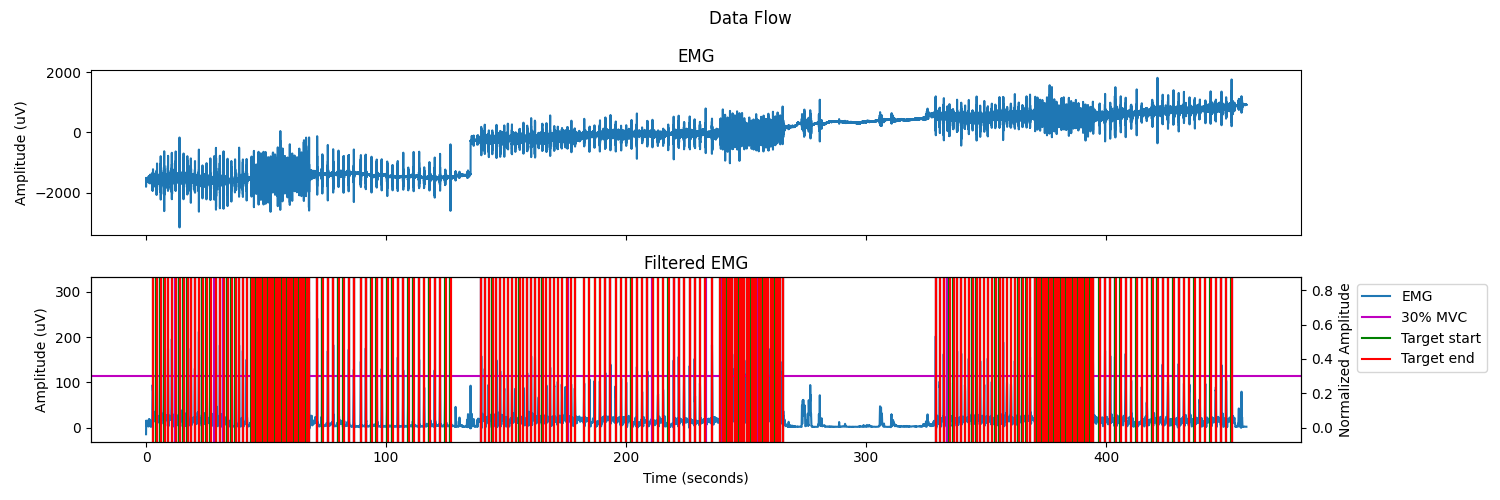

In [40]:
fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True) # dont need status or lsl clock
fig.suptitle('Data Flow')

axs[0].plot(data_timestamps_haptics, data_haptics[:, 0])
axs[0].title.set_text('EMG')

for xc in start_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='g')
for xc in stop_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='r')

axs[1].plot(data_timestamps_haptics, process.lpFilteredData, label='EMG')
axs[1].title.set_text('Filtered EMG')
axs[1].axhline(y=mvc_threshold, color='m', label='30% MVC')

for ups in data_crossed_small_haptics:
    axs[1].axvline(x=ups, color='m')

for xc in start_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='g', label='Target start')
for xc in stop_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='r', label='Target end')

    
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Amplitude (uV)')
axs[0].set_ylabel('Amplitude (uV)')
ax1_twin = axs[1].twinx()
ax1_twin.set_ylabel('Normalized Amplitude')

# set twin scale (convert degree celsius to fahrenheit)
Norm_amp = lambda amp: amp/Mvc
# get left axis limits
ymin, ymax = axs[1].get_ylim()
# apply function and set transformed values to right axis limits
ax1_twin.set_ylim((Norm_amp(ymin),Norm_amp(ymax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax1_twin.plot([],[])

# plt.legend(loc="upper right", ncol=2)
legend_without_duplicate_labels(axs[1])

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

In [20]:
print("start:", start_cue_timestamp_haptics)
print("stop:",stop_cue_timestamp_haptics)
print("corssed:",data_crossed_small_haptics)

start: [190058.386672   190059.9762841  190061.5777955  190063.1666414
 190064.7783461  190066.36275701 190067.9669251  190069.5818213
 190071.1729072  190072.783957   190074.3637135  190075.9834409
 190077.5666249  190079.1691111  190080.7800352  190082.3572817
 190084.7817114  190086.3803438  190087.9662999  190089.5656389
 190091.1659388  190092.7526208  190094.3857668  190095.9673943
 190097.5811886  190099.4767395  190100.4677915  190101.4669482
 190102.4665289  190103.4778659  190104.470685   190105.467366
 190106.4776537  190107.4668919  190108.4603701  190109.4804966
 190110.4746639  190111.4686995  190112.4713978  190113.458963
 190114.4718304  190115.4718428  190116.4852237  190117.4677559
 190118.4809336  190119.4693539  190120.4675286  190121.4713612
 190122.467889   190123.4788646  190126.871255   190129.0625027
 190131.2910839  190133.4925906  190135.6810601  190137.8784051
 190140.0730428  190142.2777489  190145.0697621  190147.2683099
 190149.4709901  190151.6807391  19

In [23]:

start_cue_timestamp_haptics = start_cue_timestamp_haptics[np.logical_or(start_cue_timestamp_haptics<264, start_cue_timestamp_haptics>266)]
stop_cue_timestamp_haptics = stop_cue_timestamp_haptics[np.logical_or(stop_cue_timestamp_haptics<264, stop_cue_timestamp_haptics>266)]

start_cue_timestamp_haptics = start_cue_timestamp_haptics[start_cue_timestamp_haptics<450]
stop_cue_timestamp_haptics = stop_cue_timestamp_haptics[stop_cue_timestamp_haptics<450]

In [24]:
# Exclude the first pulse - that is ardunio power cycling
# start_cue_timestamp = start_cue_timestamp[1:] # [1:]
# stop_cue_timestamp = stop_cue_timestamp[1:] #[1:]

threshold_closest_timestamp_haptics = np.empty(np.size(start_cue_timestamp_haptics[:]))
threshold_closest_timestamp_haptics[:] = np.nan
correct_timestamp_haptics = np.empty(np.size(start_cue_timestamp_haptics[:]))
###for every value in the strt_cue 
for idx_cue, cue in enumerate(start_cue_timestamp_haptics[:]):

    after_start_timestamp = start_cue_timestamp_haptics[idx_cue] <= data_crossed_small_haptics
    before_stop_timestamp = data_crossed_small_haptics <= stop_cue_timestamp_haptics[idx_cue]
    # check if there is a value between start_cue and stop cue
    if np.any(np.logical_and(after_start_timestamp, before_stop_timestamp)):
        in_target = np.argwhere(np.logical_and(after_start_timestamp, before_stop_timestamp))
        closet_value = in_target[0]
        threshold_closest_timestamp_haptics[idx_cue] = data_crossed_small_haptics[in_target[0]]
        correct_timestamp_haptics[idx_cue] = True
    else:
        # if not - get closet 
        idx = (np.abs(data_crossed_small_haptics - start_cue_timestamp_haptics[idx_cue])).argmin()

        threshold_closest_timestamp_haptics[idx_cue] = data_crossed_small_haptics[idx]
        correct_timestamp_haptics[idx_cue] = False
         # get rid of values greater than half the distance between the next cue 

# print("closest:", threshold_closest_timestamp)
# print("correctness:", correct_timestamp)

threshold_distance_timestamp_haptics = threshold_closest_timestamp_haptics - start_cue_timestamp_haptics
# print("distance away:", threshold_distance_timestamp)


threshold_distance_timestamp_haptics[threshold_distance_timestamp_haptics > 0.5] = NaN
threshold_distance_timestamp_haptics[threshold_distance_timestamp_haptics < -0.5] = NaN
print("distance away:", threshold_distance_timestamp_haptics)

threshold_distance_timestamp_haptics_nan = threshold_distance_timestamp_haptics[~np.isnan(threshold_distance_timestamp_haptics)]

distance away: []


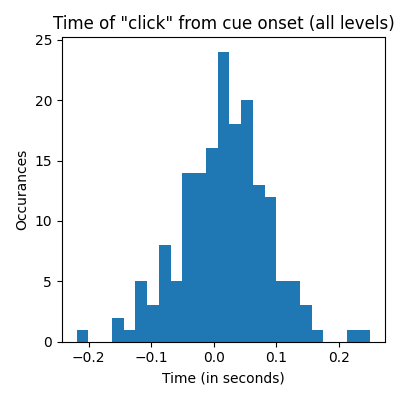

In [ ]:
plt.figure(figsize=(4,4))
plt.hist(threshold_distance_timestamp_haptics, bins=25)
plt.title('Time of "click" from cue onset (all levels)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurances')
plt.tight_layout()
plt.show()

In [ ]:
rt_normalized = (threshold_distance_timestamp_haptics_nan - np.mean(threshold_distance_timestamp_haptics_nan))/np.std(threshold_distance_timestamp_haptics_nan)
stats.kstest(rt_normalized, stats.norm.cdf)
# if p val is greater than 0.05 -> GAUSSIAN

KstestResult(statistic=0.045593274704108955, pvalue=0.8506808538233477)

C:\Users\Nikole Chetty\AppData\Local\Temp\ipykernel_26648\1532000065.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 4))


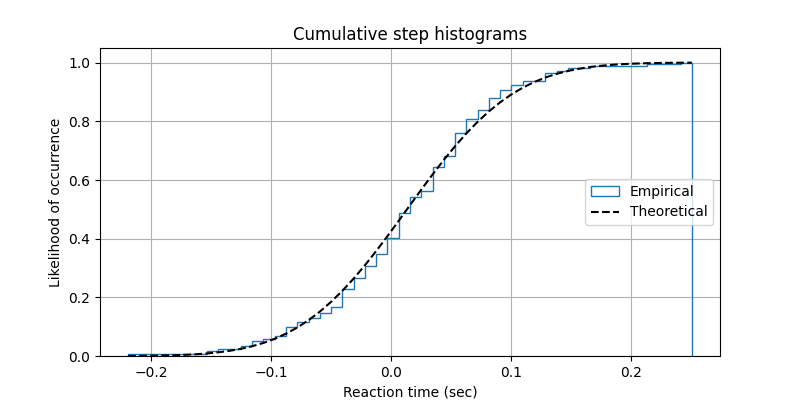

In [ ]:

np.random.seed(0)

mu = np.mean(threshold_distance_timestamp_haptics_nan)
sigma = np.std(threshold_distance_timestamp_haptics_nan)
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(threshold_distance_timestamp_haptics_nan, n_bins, density=1, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = stats.norm.pdf(bins, mu, sigma).cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')


ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Reaction time (sec)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [ ]:
repitions = gui_reps_haptics
print("repitions:", repitions)
correct_timestamp_haptics = correct_timestamp_haptics[:-1]
level = np.arange(len(correct_timestamp_haptics))//repitions
print('Levels:', level)




performance_haptics = np.bincount(level,correct_timestamp_haptics)/np.bincount(level)
print('performance per level:', performance_haptics)

repitions: 25
Levels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]
performance per level: [0.52       0.68       0.72       0.16       0.24       0.48
 0.4        0.36       0.45833333]


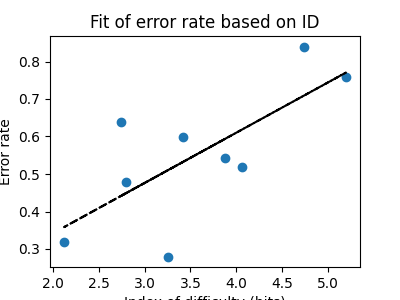

In [ ]:
coef = np.polyfit(ID_haptics,1-performance_haptics,1)
poly1d_fn = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.figure(figsize=(4,3))
plt.scatter(ID_haptics, 1-performance_haptics)
plt.plot(ID_haptics, poly1d_fn(ID_haptics), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.title('Fit of error rate based on ID')
plt.xlabel('Index of difficulty (bits)')
plt.ylabel('Error rate')
plt.show()
# plt.xlim([0, 4])
plt.ylim([0, 1.05])
plt.tight_layout()

[-0.00202291  0.85021249]


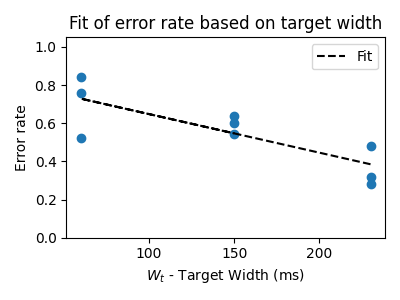

In [ ]:
wt_coef = np.polyfit(gui_combos_haptics[:,0],1-performance_haptics,1)
print(wt_coef)
wt_fn = np.poly1d(wt_coef) 

plt.figure(figsize=(4,3))
plt.scatter(gui_combos_haptics[:,0], 1-performance_haptics[0:np.shape(ID)[0]])
plt.plot(gui_combos_haptics[:, 0][0:-1:3], wt_fn(gui_combos_haptics[:, 0][0:-1:3]), '--k', label="Fit")
plt.title('Fit of error rate based on target width')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
gui_combos_haptics[:, 1][0:3]

array([1600, 1000, 2200])

[2.82407407e-05 5.08333333e-01]


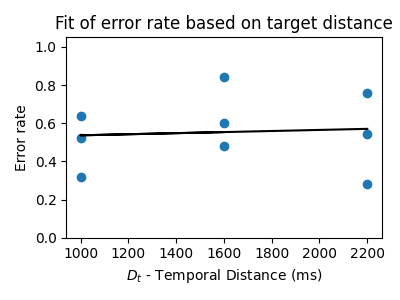

In [ ]:
dt_coef = np.polyfit(gui_combos_haptics[:,1],1-performance_haptics,1)
print(dt_coef)
dt_fn = np.poly1d(dt_coef) 

plt.figure(figsize=(4,3))
plt.scatter(gui_combos_haptics[:,1], 1-performance_haptics[0:np.shape(ID)[0]])
plt.plot(gui_combos_haptics[:, 1][0:3], dt_fn(gui_combos_haptics[:, 1][0:3]), 'k', label="Fit")
plt.title('Fit of error rate based on target distance')
plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

In [ ]:
widths = gui_combos_haptics[:,0]//60
# print(widths)
width_levels = np.repeat(widths, repitions)
# print(width_levels)

# box_plot_data_width = np.split(threshold_distance_timestamp, np.unique(width_levels, return_index=True)[1][1:])
# # print(box_plot_data_width)

width_split = [threshold_distance_timestamp_haptics[width_levels == i] for i in range(width_levels.max() + 1)]
width_split = width_split[1:]
# print(width_split)
# print(np.shape(width_split))

# width_split = width_split[~np.isnan(width_split)]
width_no_nan  = [list[~np.isnan(list)] for list in width_split]
print(width_no_nan)


[array([-0.00525  ,  0.06075  , -0.035    , -0.0890575, -0.00175  ,
        0.012    , -0.0330704,  0.0938166,  0.1478597,  0.0455   ,
        0.04325  ,  0.0493845, -0.0376763, -0.0075   ,  0.1036061,
        0.1086301,  0.0415   ,  0.007    ,  0.02225  ,  0.016    ,
       -0.05325  ,  0.01     , -0.1485961, -0.04575  ,  0.0185   ,
       -0.0903166,  0.09775  , -0.1130348,  0.1326151,  0.012    ,
       -0.04329  ,  0.001    , -0.01675  ,  0.06575  ,  0.0115   ,
       -0.0443358,  0.03575  ,  0.0601665, -0.01875  ,  0.0025   ,
        0.062257 ,  0.04075  , -0.1521629, -0.0335502, -0.0822609,
       -0.0045   ,  0.01875  ,  0.0155   ,  0.04075  ,  0.0910849,
       -0.0853065, -0.1212513]), array([-0.1194089, -0.1365696,  0.088484 , -0.06475  , -0.032    ,
        0.0555216,  0.05875  ,  0.025    ,  0.00175  , -0.00975  ,
        0.0427087,  0.0563197,  0.04125  ,  0.1166333,  0.037492 ,
       -0.02275  ,  0.04225  , -0.01025  ,  0.0725244,  0.0381595,
        0.0705175,  0.063313

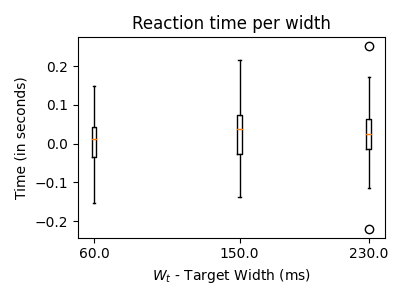

In [ ]:

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.set_title('')
ax1.boxplot(width_no_nan, positions=np.unique(gui_combos_haptics[:,0]), widths=3)
plt.title('Reaction time per width')
plt.ylabel('Time (in seconds)')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.xlim([50, 240])
plt.tight_layout()
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

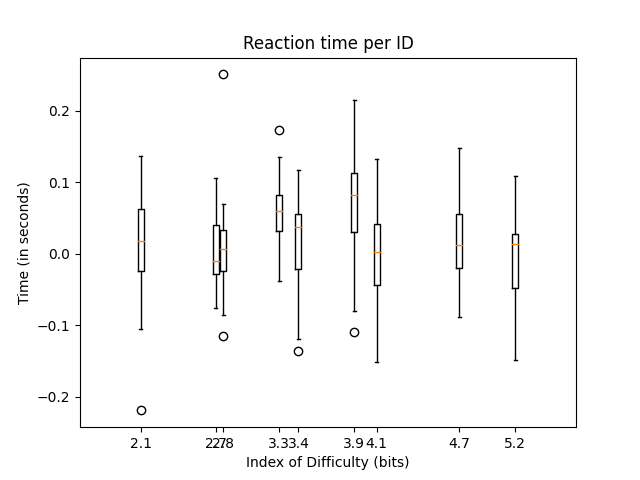

In [ ]:
box_plot_data = np.split(threshold_distance_timestamp, np.unique(level, return_index=True)[1][1:])
# print(box_plot_data)
box_plot_data_no_nan  = [list[~np.isnan(list)] for list in box_plot_data]

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(box_plot_data_no_nan, positions=ID.round(3), widths=0.05)
plt.title('Reaction time per ID')
plt.ylabel('Time (in seconds)')
plt.xlabel('Index of Difficulty (bits)')
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [ ]:
# # Exclude the first pulse - that is ardunio power cycling
# start_cue = start_cue[1:] # [1:]
# stop_cue = stop_cue[1:] #[1:]

# threshold_closest = np.empty(np.size(start_cue[:]))
# threshold_closest[:] = np.nan
# correct = np.empty(np.size(start_cue[:]))
# ###for every value in the strt_cue 
# for idx_cue, cue in enumerate(start_cue[:]):

#     after_start = start_cue[idx_cue] <= threshold_crossings_up
#     before_stop = threshold_crossings_up <= stop_cue[idx_cue]
#     # check if there is a value between start_cue and stop cue
#     if np.any(np.logical_and(after_start, before_stop)):
#         in_target = np.argwhere(np.logical_and(after_start, before_stop))
#         closet_value = in_target[0]
#         threshold_closest[idx_cue] = threshold_crossings_up[in_target[0]]
#         correct[idx_cue] = True
#     else:
#         # if not - get closet 
#         idx = (np.abs(threshold_crossings_up - start_cue[idx_cue])).argmin()

#         threshold_closest[idx_cue] = threshold_crossings_up[idx]
#         correct[idx_cue] = False
#          # get rid of values greater than half the distance between the next cue 

# print("closest:", threshold_closest)
# print("correctness:", correct)

# threshold_distance = threshold_closest - start_cue
# print("distance away:", threshold_distance)


# threshold_distance[threshold_distance > 4000] = NaN
# threshold_distance[threshold_distance < -4000] = NaN
# print("distance away:", threshold_distance)

In [ ]:
# plt.figure()
# plt.hist(threshold_distance/4000, bins=15)
# plt.title('Time of "click" from cue onset (all levels)')
# plt.xlabel('Time (in seconds)')
# plt.ylabel('Occurances')
# plt.show()

In [ ]:
# rt = threshold_distance/4000
# print(rt)
# rt = rt[~np.isnan(rt)]
# print(rt)

In [ ]:
# rt_normalized = (rt - np.mean(rt))/np.std(rt)
# stats.kstest(rt_normalized, stats.norm.cdf)
# # if p val is greater than 0.05 -> GAUSSIAN

In [ ]:


# np.random.seed(0)

# mu = np.mean(rt)
# sigma = np.std(rt)
# n_bins = 50

# fig, ax = plt.subplots(figsize=(8, 4))

# # plot the cumulative histogram
# n, bins, patches = ax.hist(rt, n_bins, density=1, histtype='step',
#                            cumulative=True, label='Empirical')

# # Add a line showing the expected distribution.
# y = stats.norm.pdf(bins, mu, sigma).cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')



# # tidy up the figure
# ax.grid(True)
# ax.legend(loc='right')
# ax.set_title('Cumulative step histograms')
# ax.set_xlabel('Reaction time (sec)')
# ax.set_ylabel('Likelihood of occurrence')

# plt.show()

In [ ]:
# repitions = gui_data['reps'] 
# print("repitions:", repitions)
# level = np.arange(len(correct))//repitions
# print('Levels:', level)
# performance = np.bincount(level,correct)/np.bincount(level)
# print('performance per level:', performance)


In [ ]:


# box_plot_data = np.split(threshold_distance/4000, np.unique(level, return_index=True)[1][1:])
# print(box_plot_data)

In [ ]:
# for idx, data in enumerate(box_plot_data):
#     box_plot_data[idx] = data[~np.isnan(data)]



In [ ]:
# fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
# ax1.boxplot(box_plot_data[0:np.shape(ID)[0]], positions=ID.round(3), widths=0.05)
# plt.title('Reaction time per ID')
# plt.ylabel('Time (in seconds)')
# plt.xlabel('Index of Difficulty (bits)')
# from matplotlib.ticker import FormatStrFormatter
# ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [ ]:
# plt.figure(figsize=(5,3))
# plt.scatter(ID, 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on ID')
# plt.xlabel('Index of difficulty (bits)')
# plt.ylabel('Error rate')
# plt.show()
# # plt.xlim([0, 4])
# plt.ylim([0, 1.05])
# plt.tight_layout()

In [ ]:
# plt.figure(figsize=(5,3))
# plt.scatter(gui_data['combos'][:,0], 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on target width')
# plt.xlabel('$W_{t}$ - Target Width (ms)')
# plt.ylabel('Error rate')
# plt.ylim([0, 1.05])
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(5,3))
# plt.scatter(gui_data['combos'][:,1], 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on target distance')
# plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
# plt.ylabel('Error rate')
# plt.ylim([0, 1.05])
# plt.tight_layout()
# plt.show()